In [90]:
# !python -m pip install scikit-learn

In [102]:
import requests
import json
from pandas import json_normalize

import pandas as pd
import numpy as np
import re
import string
import itertools
from collections import Counter

from sklearn.model_selection import train_test_split

from difflib import SequenceMatcher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from wordcloud import WordCloud
import gensim
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models
from word2number import w2n

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import ggplot, aes, geom_line, geom_point, geom_col, geom_bar, geom_density, geom_hline, geom_vline, geom_text, theme, theme_minimal, theme_classic, labs, coord_flip, scale_fill_brewer, scale_color_manual, scale_x_discrete, scale_x_continuous, scale_y_continuous, position_stack, geom_violin, element_blank

In [92]:
nltk.download('maxent_treebank_pos_tagger')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /Users/julianadaikawa/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/julianadaikawa/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/julianadaikawa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [93]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     /Users/julianadaikawa/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [94]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/julianadaikawa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [95]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/julianadaikawa/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

In [96]:
data = pd.read_csv('songs_lyrics_training.csv')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

In [97]:
# 1. Lowercase each word
# 2. Replace contractions with their longer forms
# 3. Remove special characters and unwanted words
# 4. Tokenize each word by using nltk.WordPunctTokenizer() we will extract tokens from strings of words or sentences.
# 5. Lemmatize each word by using nltk.stem.WordNetLemmatizer() we will restore words to their dictionary forms so all words with similar meanings will be linked to one word.
# 6. Removing non-English words
# 7. Removing digits as it brings no value to the meaning of songs.

In [98]:
def is_word_number(word):
    try:
        word = w2n.word_to_num(word)
    except:
        word = word
    return str(word)

def text_preprocessing(text, rm_stopwords=False, rm_non_English=False):

    # Removing NER
    ner = []
    sent1 = nltk.pos_tag(word_tokenize(text))
    sent2 = nltk.ne_chunk(sent1)
    for subtree in sent2:
        if type(subtree)==nltk.Tree and (subtree.label() == 'PERSON' or subtree.label() == 'GPE'):
            ner.append(" ".join([token for token, pos in subtree.leaves()]))
    
    text_vector = text.split()
    text_vector_wo_ner = [word for word in text_vector if word not in ner]
    text = ' '.join(text_vector_wo_ner)
    
    # Convert words to lower case
    text = text.lower()

    # using contractions.fix to expand the shortened words
    text = contractions.fix(text)

    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text) 

    # Tokenize each word
    text = nltk.WordPunctTokenizer().tokenize(text)

    # Lemmatize each word
    text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v') for token in text if len(token)>1]

    text = [is_word_number(word) for word in text]

    # Removing digits
    text = [word for word in text if np.invert(any(char.isdigit() for char in word))]
    
    if rm_stopwords:
        # Load the list of stopwords
        stopwords_list = stopwords.words('english')
        stopwords_list.extend(['oh', 'yeah', 'la', 'ya', 'ah', 'dah', 'duh', 'aa', 'li', 'da'])

        text = [word for word in text if word not in stopwords_list]

    if rm_non_English:
        English_words = set(nltk.corpus.words.words())
        text = [word for word in text if word in English_words] # or word.isdigit()

    return text
    

In [105]:
data['bow_lyrics'] = data['lyrics'].apply(lambda x: text_preprocessing(x, rm_stopwords=False, rm_non_English=False))
data['lyrics_nlp'] = data['bow_lyrics'].apply(lambda x: ' '.join(x))

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/plotnine/scales/scales.py:36: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



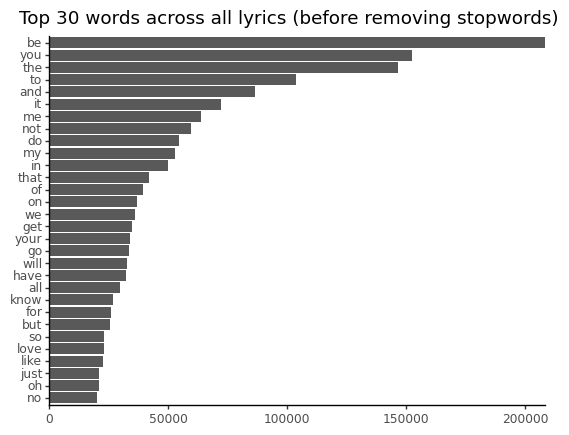

<ggplot: (688498403)>

In [106]:
# Join all word corpus
all_words = ','.join(list(data['lyrics_nlp'].values))

# Count and find the 30 most frequent
most_frequent = Counter(all_words.split()).most_common(30)
most_frequent_df = pd.DataFrame(most_frequent).rename({0:'word',1:'count'},axis=1)

# Bar plot of frequent words
(
    ggplot(most_frequent_df)  
    + aes(x="word", y="count")  
    + theme_classic()
    + scale_y_continuous(expand=(0, 0, 0, 0))
    + scale_x_continuous(expand=(0, 0, 0, 0))
    + theme(legend_position = (0.5, 0.01),
            legend_title=element_blank())
    + geom_col()  
    + scale_x_discrete(limits=most_frequent_df['word'].tolist()[::-1])
    # + scale_y_continuous(expand=(0, 0, 0.2, 0))
    + labs(title='Top 30 words across all lyrics (before removing stopwords)',x='',y='')
    + coord_flip()
    + theme(legend_position="none") 
)

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/plotnine/scales/scales.py:36: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



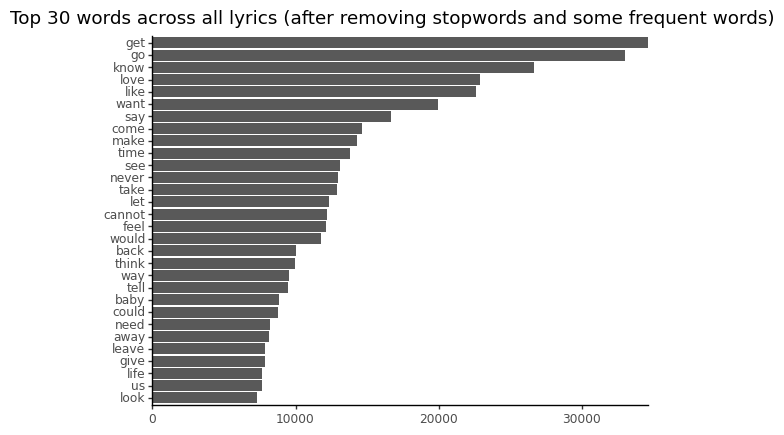

<ggplot: (696093135)>

In [104]:
data['bow_lyrics'] = data['lyrics'].apply(lambda x: text_preprocessing(x, rm_stopwords=True, rm_non_English=True))
data['lyrics_nlp'] = data['bow_lyrics'].apply(lambda x: ' '.join(x))

# Join all word corpus
all_words = ','.join(list(data['lyrics_nlp'].values))

# Count and find the 30 most frequent
most_frequent = Counter(all_words.split()).most_common(30)
most_frequent_df = pd.DataFrame(most_frequent).rename({0:'word',1:'count'},axis=1)

# Bar plot of frequent words
(
    ggplot(most_frequent_df)  
    + aes(x="word", y="count")  
    + theme_classic()
    + scale_y_continuous(expand=(0, 0, 0, 0))
    + scale_x_continuous(expand=(0, 0, 0, 0))
    + theme(legend_position = (0.5, 0.01),
            legend_title=element_blank())
    + geom_col()  
    + scale_x_discrete(limits=most_frequent_df['word'].tolist()[::-1])
    # + scale_y_continuous(expand=(0, 0, 0.2, 0))
    + labs(title='Top 30 words across all lyrics (after removing stopwords and some frequent words)',x='',y='')
    + coord_flip()
    + theme(legend_position="none") 
)

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
/

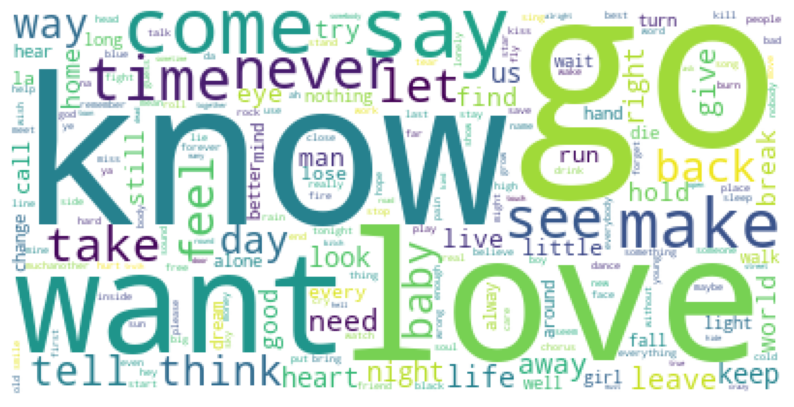

In [16]:
# Generate the word cloud
wordcloud = WordCloud(background_color="white",
                      max_words= 200,
                      contour_width = 8,
                      contour_color = "steelblue",
                      collocations=False).generate(all_words)
                      
# Visualize the word cloud
fig = plt.figure(1, figsize = (10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [101]:
data.to_csv('songs_lyrics_post_preprocessing.csv')

In [18]:
# We will separate a random portion of the dataset to test our model later.
train, test = train_test_split(data, test_size=0.1, random_state=42)

In [19]:
# Now let's stack lyrics for each topic
train_grouped = train.groupby('topic')['lyrics_nlp'].apply(list).reset_index(name='lyrics')
train_grouped['lyrics'] = train_grouped['lyrics'].apply(lambda x: ' '.join(x))
train_grouped['bow_lyrics'] = train_grouped['lyrics'].apply(lambda x: text_preprocessing(x, rm_stopwords=False, rm_non_English=False))

In [20]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(train.lyrics_nlp.values[0:10])
idf = vectorizer.idf_
feature_names = vectorizer.get_feature_names_out()
dense = tfidf.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
df # 5738 - 4657 - 4549

,air,alive,alone,along,always,another,answer,apart,arm,around,...,word,work,world,would,wrap,wrong,ya,yellow,yes,young
0,0.000000,0.000000,0.0000,0.000000,0.086640,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.086640,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.0000,0.039149,0.000000,0.000000,0.000000,0.000000,0.046052,0.046052,...,0.000000,0.000000,0.000000,0.000000,0.046052,0.000000,0.000000,0.000000,0.000000,0.046052
2,0.000000,0.086505,0.0000,0.000000,0.073537,0.073537,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.046438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.1957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.035019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.084787,0.169574,0.045516,0.000000,0.084787,0.000000,0.000000,0.169574,0.000000
5,0.367029,0.000000,0.0000,0.000000,0.000000,0.000000,0.040781,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.021892,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.0000,0.118581,0.000000,0.118581,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.074883,0.000000,0.000000,0.278985,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.074774,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.083148,0.000000,0.000000,...,0.070683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166296,0.000000,0.000000


In [21]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(train['bow_lyrics'])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in train['bow_lyrics']]

# Compute coherence score
number_of_topics = []
coherence_score = []
for i in range(1,100):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           iterations=50,
                                           num_topics=i)
  coherence_model_lda = CoherenceModel(model=lda_model, 
                                       texts=train['bow_lyrics'], 
                                       dictionary=id2word, 
                                       coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  number_of_topics.append(i)
  coherence_score.append(coherence_lda)

# Create a dataframe of coherence score by number of topics 
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics,
                                'coherence_score':coherence_score})

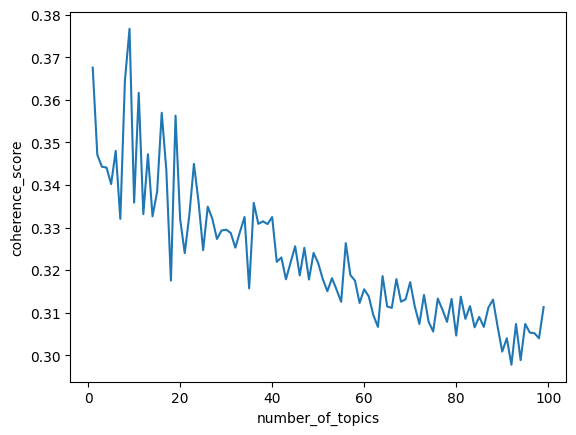

In [24]:
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')
plt.show()

In [25]:
topic_coherence[topic_coherence['coherence_score']==max(topic_coherence.coherence_score)]

,number_of_topics,coherence_score
8,9,0.376683


In [27]:
# Define the number of topics 
n_topics = 10

# Run the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=0,
                                           chunksize=100000,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [28]:
# Import and enable notebook to run visualization
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, 
                                     corpus, 
                                     dictionary=lda_model.id2word)
vis

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.065346  0.047360       1        1  20.658560
0      0.058631  0.000128       2        1  14.156067
2      0.022816 -0.006759       3        1  14.034377
3     -0.027976 -0.039120       4        1  12.456053
9      0.019648  0.010318       5        1  12.106473
7      0.057941  0.068642       6        1   6.840191
6      0.017197 -0.003129       7        1   6.600742
8     -0.007376 -0.028951       8        1   6.174390
1     -0.037893 -0.126836       9        1   4.023262
5     -0.168335  0.078346      10        1   2.949885, topic_info=      Term          Freq         Total Category  logprob  loglift
16    love  22161.000000  22161.000000  Default  30.0000  30.0000
51     get  30918.000000  30918.000000  Default  29.0000  29.0000
439     la   3547.000000   3547.000000  Default  28.0000  28.0000
31    want  18034.000000  18034.000000  Default  27.0000  27.0000
60    like  20306.000000  20306.000000  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
280     ya    193.398462   2178.817042  Topic10  -5.4126   1.1016
58    life    199.742420   7269.507845  Topic10  -5.3803  -0.0710
151   need    194.353308   7389.557164  Topic10  -5.4077  -0.1147
152  never    197.166899  12527.517307  Topic10  -5.3933  -0.6282
4     come    195.346600  13327.108545  Topic10  -5.4026  -0.6994

[873 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
8545       4  0.051697          aa
8545       8  0.930545          aa
8216       7  0.915731     absolve
12377      8  0.928935  adjustment
10821      3  0.083605   advertise
...      ...       ...         ...
1298       4  0.387711          €™
1298       6  0.556281          €™
1298       8  0.014047          €™
1298       9  0.002809          €™
1298      10  0.016857          €™

[3497 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 4, 10, 8, 7, 9, 2, 6])

In [29]:
data['topic_lda_class'] = data['bow_lyrics'].apply(lambda x: max(lda_model.get_document_topics(id2word.doc2bow(x)),key=lambda item:item[1])[0])
data['topic_lda_class_prob'] = data['bow_lyrics'].apply(lambda x: max(lda_model.get_document_topics(id2word.doc2bow(x)),key=lambda item:item[1])[1])

In [41]:
data[data['bow_lyrics'].apply(lambda x: 'yeah' in x)]
# 'oh', 'no', 'yeah', 'la', 'da', 'ya'

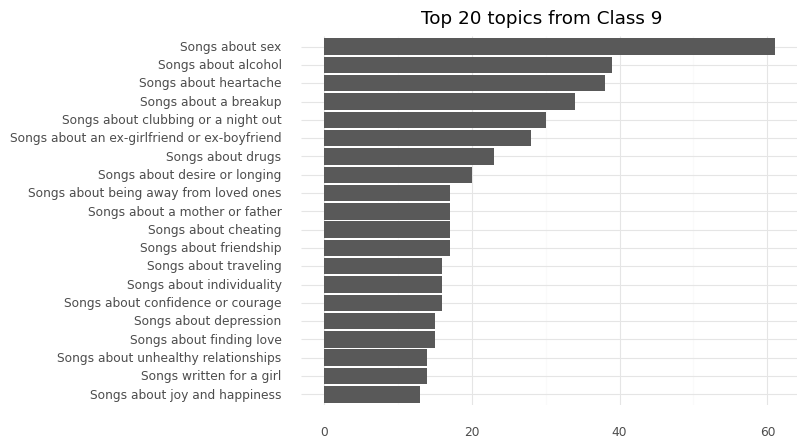

<ggplot: (393344379)>

In [31]:
i=9
topic_lda_all = data[data['topic_lda_class_prob']>0.6].groupby(['topic_lda_class','topic']).size().reset_index(name='n').sort_values('n', ascending=False)
topic_i = topic_lda_all[topic_lda_all['topic_lda_class']==i]
topic_i = topic_i.sort_values('n', ascending=False)
topic_i = topic_i.head(20)

# Bar plot of frequent words
(
    ggplot(topic_i)  
    + aes(x="topic", y="n")  
    + theme_minimal()
    + geom_col()  
    + scale_x_discrete(limits=topic_i['topic'].tolist()[::-1])
    # + scale_y_continuous(expand=(0, 0, 0.2, 0))
    + labs(title="Top 20 topics from Class {}".format(i),x='',y='')
    + coord_flip()
    + theme(legend_position="none") 
)

In [145]:
topic_lda_all = data.groupby(['topic_lda_class','topic']).size().reset_index(name='n').sort_values('n', ascending=False)
topic_lda_all['perc'] = topic_lda_all['n'] / topic_lda_all.groupby('topic_lda_class')['n'].transform('sum')
topic_lda_all = topic_lda_all.sort_values(['topic_lda_class','perc'], ascending=False)
topic_lda_all[topic_lda_all['topic_lda_class']==0]

,topic_lda_class,topic,n,perc
179,0,Songs about war,134,0.061215
155,0,Songs about spirituality or religion,125,0.057104
186,0,Songs with political statements,97,0.044312
66,0,Songs about events in the news,73,0.033349
56,0,Songs about death,66,0.030151
...,...,...,...,...
40,0,Songs about celebrity culture,1,0.000457
83,0,Songs about gossip or rumors,1,0.000457
1,0,Kiss-off songs,1,0.000457
61,0,Songs about dogs,1,0.000457


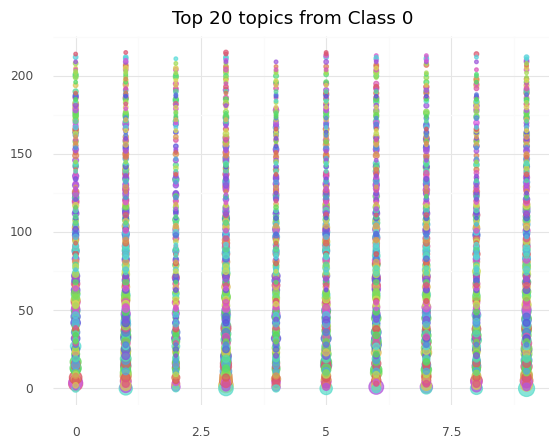

<ggplot: (701819535)>

In [148]:
topic_lda_all = data.groupby(['topic_lda_class','topic']).size().reset_index(name='n').sort_values('n', ascending=False)
topic_lda_all['k'] = topic_lda_all['topic'].factorize()[0]

# Bar plot of frequent words
(
    ggplot(topic_lda_all)  
    + aes(x="topic_lda_class", y="k")  
    + theme_minimal()
    + geom_point(aes(color="topic",size = 'n'), alpha=0.7)  
    # + scale_y_continuous(expand=(0, 0, 0.2, 0))
    + labs(title="Top 20 topics from Class {}".format(i),x='',y='')
    # + coord_flip()
    + theme(legend_position="none") 
)

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/plotnine/positions/position.py:202: PlotnineWarning: position_dodge requires non-overlapping x intervals


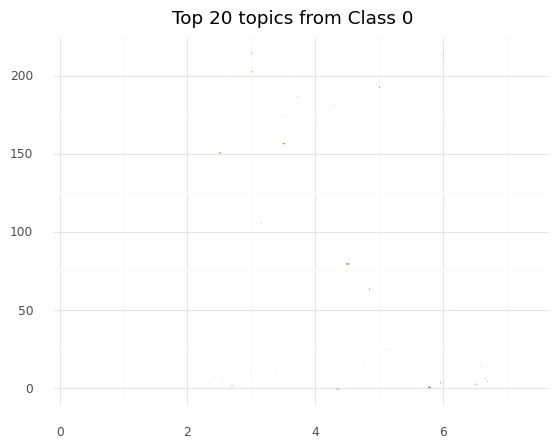

<ggplot: (700451072)>

In [152]:
topic_lda_all = data.groupby(['topic_lda_class','topic']).size().reset_index(name='n').sort_values('n', ascending=False)
topic_lda_all['k'] = topic_lda_all['topic'].factorize()[0]

# Bar plot of frequent words
(
    ggplot(topic_lda_all)  
    + aes(x="topic_lda_class", y="k", color="topic")  
    + theme_minimal()
    + geom_violin()
    # + scale_y_continuous(expand=(0, 0, 0.2, 0))
    + labs(title="Top 20 topics from Class {}".format(i),x='',y='')
    # + coord_flip()
    + theme(legend_position="none") 
)

In [89]:
data[data['topic_lda_class_prob']>0.6].groupby(['topic_lda_class','topic']).size().reset_index(name='n').sort_values('n', ascending=False).groupby(['topic_lda_class']).head(10)

,topic_lda_class,topic,n
70,2,Songs about heartache,14
99,2,Songs about spirituality or religion,11
138,6,Songs about a breakup,10
108,2,Songs written for a girl,9
143,6,Songs about an ex-girlfriend or ex-boyfriend,9
...,...,...,...
116,3,Songs about heartache,1
117,3,Songs about places,1
118,3,Songs about sex,1
119,3,Songs written for a girl,1
